In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner
from psiam_tied_dv_map_utils import rho_A_t_fn, up_RTs_fit_fn, down_RTs_fit_fn, up_RTs_fit_single_t_fn, psiam_tied_data_gen_wrapper
from psiam_tied_dv_map_utils import cum_A_t_fn, cum_E_t_fn, down_RTs_fit_TRUNC_fn, up_RTs_fit_TRUNC_fn


In [3]:
import pickle
with open('../fitting_aborts/post_led_censor_test_vbmc.pkl', 'rb') as f:
    vp = pickle.load(f)

In [4]:
vp_sample = vp.sample(int(1e6))[0]

V_A = np.mean(vp_sample[:,0])
theta_A = np.mean(vp_sample[:,1])
t_motor = 0.04

# t_A_aff = np.mean(vp_sample[:,2]) - t_motor
t_A_aff = 0.05

In [5]:
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


Text(0.5, 1.0, 'data')

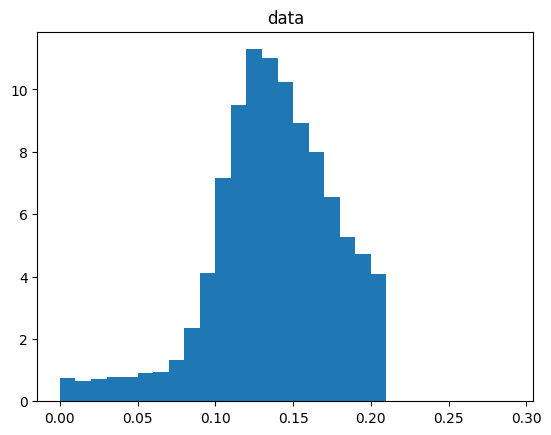

In [6]:
df_led_off = df[df['LED_trial'] == 0]
df_led_off_valid_trials = df_led_off[ df_led_off['timed_fix'] > df_led_off['intended_fix']]
df_led_off_truncated_trials = df_led_off_valid_trials[ df_led_off_valid_trials['timed_fix']- df_led_off_valid_trials['intended_fix'] < 0.21]

rt_wrt_stim = df_led_off_truncated_trials['timed_fix'] - df_led_off_truncated_trials['intended_fix']

bins = np.arange(0, 0.3, 0.01)
plt.hist(rt_wrt_stim, bins=bins, density=True);
plt.title('data')

In [7]:
N_sim = int(1e6)
N_print = int(1e6 + 1)
dt = 1e-3; dB = np.sqrt(dt);

rate_lambda = 0.076
theta_E = 50
T_0 = 0.19 * (1e-3)

t_E_aff = 0.03
Z_E = 0
L = 1

t_stim_0 = 0.2; t_stim_tau = 0.4

sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper)(V_A, theta_A, [ABL_arr[-1]], [ILD_arr[0]], rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, t_motor, L, \
                                t_stim_0, t_stim_tau, iter_num, N_print, dt) for iter_num in range(N_sim))

In iter_num: 0, ABL: 60, ILD: -16.0, t_stim: 0.2284314398382966


In [8]:
T_trunc_right = 0.21
T_trunc_abort = 0.3

# like vbmc

In [21]:
from joblib import Parallel, delayed

# parallel
K_max = 10
t_pts = np.arange(0, 2, 0.01)
all_t_stim = [res['t_stim'] for res in sim_results]
N_samp = 100_000
sampled_t_stim = np.random.choice(all_t_stim, N_samp)
pdf_vs_t_stim = np.zeros((N_samp, len(t_pts)))

trunc_left_cum_A = 1 - cum_A_t_fn(T_trunc_abort-t_A_aff, V_A, theta_A)

def compute_pdf_for_stim(t_stim):
    pdf_for_each_stim = np.zeros_like(t_pts)
    for t_id, t in enumerate(t_pts):
        if t - t_stim > T_trunc_right:
            pdf_for_each_stim[t_id] = 0
        else:
            cum_proactive = cum_A_t_fn(T_trunc_right - t_A_aff, V_A, theta_A) / trunc_left_cum_A
            cum_reactive = cum_E_t_fn(T_trunc_right - t_E_aff, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, K_max)
            cum_trunc = cum_proactive + cum_reactive - cum_proactive * cum_reactive

            up_like = up_RTs_fit_TRUNC_fn([t], V_A, theta_A, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0, \
                                        theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max, T_trunc_abort)[0]
                              
            down_like = down_RTs_fit_TRUNC_fn([t], V_A, theta_A, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0,\
                                            theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max, T_trunc_abort)[0]
            likelihood = up_like + down_like
            pdf_for_each_stim[t_id] = likelihood / cum_trunc
    return pdf_for_each_stim

results = Parallel(n_jobs=30)(delayed(compute_pdf_for_stim)(t_stim) for t_stim in tqdm(sampled_t_stim))
pdf_vs_t_stim = np.array(results)

100%|██████████| 100000/100000 [04:59<00:00, 334.01it/s]


# no choice

In [19]:
from joblib import Parallel, delayed
from psiam_tied_no_dv_map_utils import rho_A_t_fn, cum_A_t_fn, rho_E_minus_small_t_NORM_fn
from psiam_tied_dv_map_utils import cum_E_t_fn
# parallel 
############## A diff PDF #############
K_max = 10
t_pts = np.arange(0, 2, 0.01)
all_t_stim = [res['t_stim'] for res in sim_results]
N_samp = 100_000
sampled_t_stim = np.random.choice(all_t_stim, N_samp)
pdf_vs_t_stim = np.zeros((N_samp, len(t_pts)))

trunc_left_cum_A = 1 - cum_A_t_fn(T_trunc_abort-t_A_aff, V_A, theta_A)
def compute_pdf_for_stim(t_stim):
    pdf_for_each_stim = np.zeros_like(t_pts)
    for t_id, t in enumerate(t_pts):
        if t - t_stim > T_trunc_right:
            pdf_for_each_stim[t_id] = 0
        else:
            if T_trunc_right + t_stim  < T_trunc_abort:
                cum_proactive = 0
            else:
                cum_proactive = cum_A_t_fn(T_trunc_right + t_stim - t_A_aff - t_motor, V_A, theta_A) / trunc_left_cum_A
            cum_reactive = cum_E_t_fn(T_trunc_right + t_stim - t_E_aff - t_motor - t_stim, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, K_max)
            cum_trunc = cum_proactive + cum_reactive - cum_proactive * cum_reactive

            # up_like = up_RTs_fit_TRUNC_fn([t], V_A, theta_A, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0, \
            #                             theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max, T_trunc_abort)[0]
                              
            # down_like = down_RTs_fit_TRUNC_fn([t], V_A, theta_A, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0,\
                                            # theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max, T_trunc_abort)[0]

            p_a = 0 if t < T_trunc_abort else rho_A_t_fn(t - t_A_aff - t_motor, V_A, theta_A) / trunc_left_cum_A
            c_e = cum_E_t_fn(t - t_stim, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, K_max) 

            p_e = rho_E_minus_small_t_NORM_fn(t - t_E_aff - t_motor - t_stim, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, 1, K_max) \
                + rho_E_minus_small_t_NORM_fn(t - t_E_aff - t_motor - t_stim, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, -1, K_max)
            c_a = 0 if t < T_trunc_abort else cum_A_t_fn(t - t_A_aff - t_motor, V_A, theta_A) / trunc_left_cum_A
            likelihood = p_a * (1 - c_e) + p_e * (1 - c_a)
            
            pdf_for_each_stim[t_id] = likelihood / cum_trunc
    return pdf_for_each_stim


results = Parallel(n_jobs=30)(delayed(compute_pdf_for_stim)(t_stim) for t_stim in tqdm(sampled_t_stim))
pdf_vs_t_stim = np.array(results)

100%|██████████| 100000/100000 [01:46<00:00, 938.88it/s]


# no proactive truncation

In [39]:
from joblib import Parallel, delayed
from psiam_tied_no_dv_map_utils import rho_A_t_fn, cum_A_t_fn, rho_E_minus_small_t_NORM_fn
from psiam_tied_dv_map_utils import cum_E_t_fn
# parallel 
############## A diff PDF #############
########### No proactive truncation 
K_max = 10
t_pts = np.arange(0, 2, 0.01)
all_t_stim = [res['t_stim'] for res in sim_results]
N_samp = 100_000
sampled_t_stim = np.random.choice(all_t_stim, N_samp)
pdf_vs_t_stim = np.zeros((N_samp, len(t_pts)))

def compute_pdf_for_stim(t_stim):
    pdf_for_each_stim = np.zeros_like(t_pts)
    for t_id, t in enumerate(t_pts):
        if t - t_stim > T_trunc_right:
            pdf_for_each_stim[t_id] = 0
        elif t < t_stim:
            pdf_for_each_stim[t_id] = 0
        else:
            p_a = rho_A_t_fn(t - t_A_aff - t_motor, V_A, theta_A)
            c_e = cum_E_t_fn(t - t_stim, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, K_max) 

            p_e = rho_E_minus_small_t_NORM_fn(t - t_E_aff - t_motor - t_stim, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, 1, K_max) \
                + rho_E_minus_small_t_NORM_fn(t - t_E_aff - t_motor - t_stim, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, -1, K_max)
            c_a = cum_A_t_fn(t - t_A_aff - t_motor, V_A, theta_A)
            likelihood = p_a * (1 - c_e) + p_e * (1 - c_a)
            
            pdf_for_each_stim[t_id] = likelihood
    return pdf_for_each_stim


results = Parallel(n_jobs=30)(delayed(compute_pdf_for_stim)(t_stim) for t_stim in tqdm(sampled_t_stim))
pdf_vs_t_stim = np.array(results)

100%|██████████| 100000/100000 [00:31<00:00, 3178.23it/s]


Text(0.5, 1.0, 'valid trials btn 0 and 0.21')

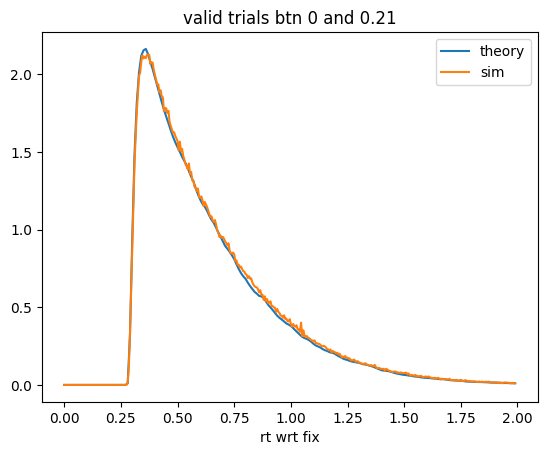

In [43]:
pdf_vs_t_stim_mean = np.mean(pdf_vs_t_stim, axis=0)
plt.plot(t_pts, pdf_vs_t_stim_mean);

bins = np.arange(0, 2, 0.005)
valid_rt_less_than_trunc = [res['rt'] for res in sim_results if res['rt'] > res['t_stim'] and res['rt'] - res['t_stim'] < T_trunc_right]
valid_rt_less_than_trunc_hist, _ = np.histogram(valid_rt_less_than_trunc, bins=bins, density=True)
valid_rt_less_than_trunc_hist *= len(valid_rt_less_than_trunc) / len(sim_results)

plt.plot(bins[:-1], valid_rt_less_than_trunc_hist)

plt.legend(['theory', 'sim'])
plt.xlabel('rt wrt fix');
plt.title('valid trials btn 0 and 0.21')                 

# all valid rt

In [33]:
from joblib import Parallel, delayed
from psiam_tied_no_dv_map_utils import rho_A_t_fn, cum_A_t_fn, rho_E_minus_small_t_NORM_fn
from psiam_tied_dv_map_utils import cum_E_t_fn

# parallel 
# ALL valid rt # 

K_max = 10
t_pts = np.arange(0, 2, 0.01)
all_t_stim = [res['t_stim'] for res in sim_results]
N_samp = 100_000
sampled_t_stim = np.random.choice(all_t_stim, N_samp)
pdf_vs_t_stim = np.zeros((N_samp, len(t_pts)))

def compute_pdf_for_stim(t_stim):
    pdf_for_each_stim = np.zeros_like(t_pts)
    
    cum_proactive = cum_A_t_fn(t_stim - t_A_aff - t_motor, V_A, theta_A)
    cum_trunc = 1 - cum_proactive
    for t_id, t in enumerate(t_pts):
        if t < t_stim - t_A_aff - t_motor:
            pdf_for_each_stim[t_id] = 0
        else:
            p_a = rho_A_t_fn(t - t_A_aff - t_motor, V_A, theta_A)
            c_e = cum_E_t_fn(t - t_stim, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, K_max) 
            p_e = rho_E_minus_small_t_NORM_fn(t - t_E_aff - t_motor - t_stim, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, 1, K_max) \
                + rho_E_minus_small_t_NORM_fn(t - t_E_aff - t_motor - t_stim, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, -1, K_max)
            c_a = cum_A_t_fn(t - t_A_aff - t_motor, V_A, theta_A)
            likelihood = p_a * (1 - c_e) + p_e * (1 - c_a)
        
            pdf_for_each_stim[t_id] = likelihood
    return pdf_for_each_stim


results = Parallel(n_jobs=30)(delayed(compute_pdf_for_stim)(t_stim) for t_stim in sampled_t_stim)
pdf_vs_t_stim = np.array(results)

n aborts = 69361 / 1000000


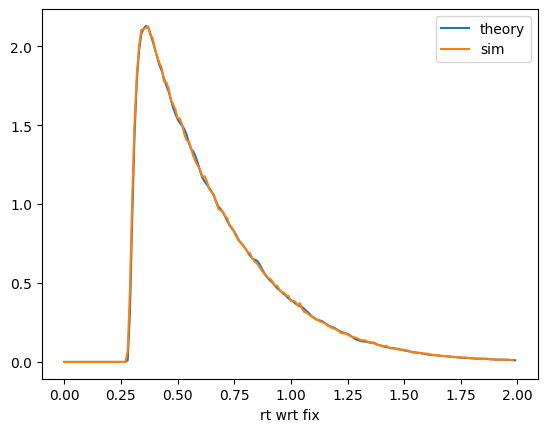

In [34]:
plt.plot(t_pts, np.mean(pdf_vs_t_stim, axis=0));

bins = np.arange(0, 2, 0.01)
# plt.hist([res['rt'] for res in sim_results if res['rt'] > res['t_stim'] ], bins=bins, density=True, alpha=0.5);
valid_rt = [res['rt'] for res in sim_results if res['rt'] > res['t_stim']]
n_aborts = len(sim_results) - len(valid_rt)
print(f'n aborts = {n_aborts} / {len(sim_results)}')
valid_rt_hist, _ = np.histogram(valid_rt, bins=bins, density=True)
valid_rt_hist *= ( 1 - (n_aborts / len(sim_results)) )
plt.plot(bins[:-1], valid_rt_hist)

plt.legend(['theory', 'sim'])
plt.xlabel('rt wrt fix');                 

In [35]:
1 - np.trapz(np.mean(pdf_vs_t_stim, axis=0), t_pts), 1 - np.trapz(valid_rt_hist, bins[:-1])

(0.07519417462906697, 0.0694146817002681)

# all valid rt wrt stim?

In [31]:
from joblib import Parallel, delayed
from psiam_tied_no_dv_map_utils import rho_A_t_fn, cum_A_t_fn, rho_E_minus_small_t_NORM_fn
from psiam_tied_dv_map_utils import cum_E_t_fn

# parallel 
# ALL valid rt wrt stim # 

K_max = 10
t_pts = np.arange(-1, 1, 0.01)
all_t_stim = [res['t_stim'] for res in sim_results]
N_samp = 100_000
sampled_t_stim = np.random.choice(all_t_stim, N_samp)
pdf_vs_t_stim = np.zeros((N_samp, len(t_pts)))

def compute_pdf_for_stim(t_stim):
    pdf_for_each_stim = np.zeros_like(t_pts)
    
    cum_proactive = cum_A_t_fn(t_stim, V_A, theta_A)
    cum_trunc = 1 - cum_proactive
    for t_id, t in enumerate(t_pts):
        t += t_stim
        if t <= 0:
            pdf_for_each_stim[t_id] = 0
        else:
            p_a = rho_A_t_fn(t - t_A_aff - t_motor, V_A, theta_A)
            c_e = cum_E_t_fn(t - t_stim, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, K_max) 
            p_e = rho_E_minus_small_t_NORM_fn(t - t_E_aff - t_motor - t_stim, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, 1, K_max) \
                + rho_E_minus_small_t_NORM_fn(t - t_E_aff - t_motor - t_stim, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, -1, K_max)
            c_a = cum_A_t_fn(t - t_A_aff - t_motor, V_A, theta_A)
            likelihood = p_a * (1 - c_e) + p_e * (1 - c_a)
        
            pdf_for_each_stim[t_id] = likelihood / cum_trunc
    return pdf_for_each_stim


results = Parallel(n_jobs=30)(delayed(compute_pdf_for_stim)(t_stim) for t_stim in sampled_t_stim)
pdf_vs_t_stim = np.array(results)

n aborts = 69361 / 1000000


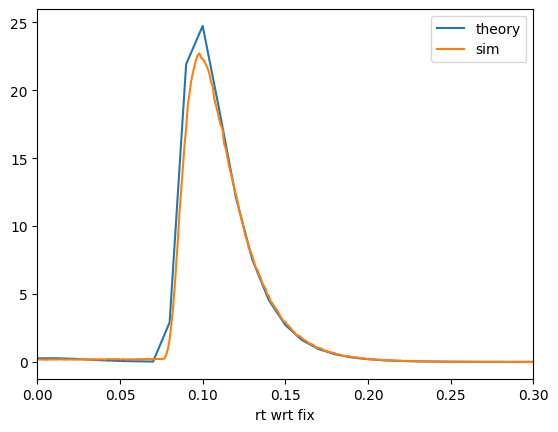

In [32]:
plt.plot(t_pts, np.mean(pdf_vs_t_stim, axis=0));

bins = np.arange(0, 1, 0.001)
# plt.hist([res['rt'] for res in sim_results if res['rt'] > res['t_stim'] ], bins=bins, density=True, alpha=0.5);
valid_rt = [res['rt'] - res['t_stim'] for res in sim_results if res['rt'] > res['t_stim']]
n_aborts = len(sim_results) - len(valid_rt)
print(f'n aborts = {n_aborts} / {len(sim_results)}')
valid_rt_hist, _ = np.histogram(valid_rt, bins=bins, density=True)
valid_rt_hist *= ( 1 - (n_aborts / len(sim_results)) )
plt.plot(bins[:-1], valid_rt_hist)

plt.legend(['theory', 'sim'])
plt.xlabel('rt wrt fix');       
plt.xlim(0,0.3);          

# fit everything

In [71]:
from joblib import Parallel, delayed
from psiam_tied_no_dv_map_utils import rho_A_t_fn, cum_A_t_fn, rho_E_minus_small_t_NORM_fn
from psiam_tied_dv_map_utils import cum_E_t_fn

# parallel 
# ALL valid rt # 

K_max = 10
t_pts = np.arange(0, 2, 0.01)
all_t_stim = [res['t_stim'] for res in sim_results]
N_samp = 10_000
sampled_t_stim = np.random.choice(all_t_stim, N_samp)
pdf_vs_t_stim = np.zeros((N_samp, len(t_pts)))
def compute_pdf_for_stim(t_stim):
    pdf_for_each_stim = np.zeros_like(t_pts)
    
    for t_id, t in enumerate(t_pts):
        p_a = rho_A_t_fn(t - t_A_aff - t_motor, V_A, theta_A)
        c_e = cum_E_t_fn(t - t_stim, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, K_max) 

        p_e = rho_E_minus_small_t_NORM_fn(t - t_E_aff - t_motor - t_stim, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, 1, K_max) \
            + rho_E_minus_small_t_NORM_fn(t - t_E_aff - t_motor - t_stim, ABL_arr[-1], ILD_arr[0], rate_lambda, T_0, theta_E, Z_E, -1, K_max)
        c_a = cum_A_t_fn(t - t_A_aff - t_motor, V_A, theta_A)
        likelihood = p_a * (1 - c_e) + p_e * (1 - c_a)
        
        pdf_for_each_stim[t_id] = likelihood
    return pdf_for_each_stim


results = Parallel(n_jobs=30)(delayed(compute_pdf_for_stim)(t_stim) for t_stim in tqdm(sampled_t_stim))
pdf_vs_t_stim = np.array(results)

100%|██████████| 100000/100000 [03:10<00:00, 524.84it/s]


In [161]:
N_samp = 1_000_000
# sampled_t_stim = np.random.choice(all_t_stim, N_samp)
sampled_t_stim = np.random.exponential(0.4, N_samp) + 0.2

def compute_frac_of_aborts(t_stim):
    return cum_A_t_fn(t_stim - t_A_aff - t_motor, V_A, theta_A)

frac_of_aborts = np.array(Parallel(n_jobs=30)(delayed(compute_frac_of_aborts)(t_stim) for t_stim in sampled_t_stim))
print('theory = ',frac_of_aborts.mean())
data_frac = len([res['rt'] for res in sim_results if res['rt'] < res['t_stim']]) / len(sim_results)
print('data = ', data_frac)

print(f'diff = {frac_of_aborts.mean() - data_frac}')

theory =  0.07130464580657782
data =  0.069867
diff = 0.0014376458065778197


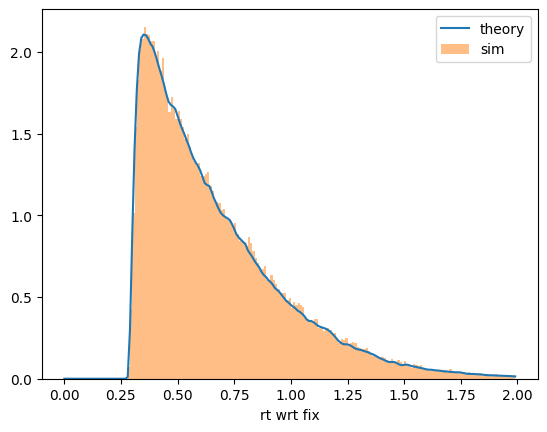

In [72]:
plt.plot(t_pts, np.mean(pdf_vs_t_stim, axis=0));

bins = np.arange(0, 2, 0.01)
plt.hist([res['rt'] for res in sim_results ], bins=bins, density=True, alpha=0.5);

plt.legend(['theory', 'sim'])
plt.xlabel('rt wrt fix');                 